In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
import matplotlib.pyplot as plt # For accuracy plot
from tqdm import tqdm # For progress bars

# Import from other modules
from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

/home/ngo/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="vit"):
    criterion = nn.CrossEntropyLoss()

    # AdamW is often recommended for Transformers
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Adjust step_size for 20 epochs

    model.to(device)
    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        model.eval()
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time

        current_lr = scheduler.get_last_lr()[0]

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {current_lr:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        scheduler.step()

        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history

Sử dụng thiết bị: cuda
Files already downloaded and verified
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Files already downloaded and verified
Files already downloaded and verified
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo 7_1_ViT_B_16_small_lr pre-trained model...
Replaced ViT classifier head (model.heads.head) with Linear(768, 100)
Bắt đầu fine-tuning 7_1_ViT_B_16_small_lr...


Epoch 1/20 [Val]: 100%|██████████| 209/209 [01:03<00:00,  3.27it/s]


Epoch 1/20 | Train Loss: 1.8896 | Train Acc: 54.08% | Test Acc: 80.70% | LR: 0.000050 | Duration: 1116.20s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 80.70%


Epoch 2/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.22it/s]


Epoch 2/20 | Train Loss: 1.1593 | Train Acc: 68.85% | Test Acc: 82.26% | LR: 0.000050 | Duration: 1127.06s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 82.26%


Epoch 3/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.26it/s]


Epoch 3/20 | Train Loss: 0.9905 | Train Acc: 72.84% | Test Acc: 84.40% | LR: 0.000050 | Duration: 1125.48s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 84.40%


Epoch 4/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.25it/s]


Epoch 4/20 | Train Loss: 0.8826 | Train Acc: 75.45% | Test Acc: 85.10% | LR: 0.000050 | Duration: 1126.19s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 85.10%


Epoch 5/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.24it/s]


Epoch 5/20 | Train Loss: 0.8165 | Train Acc: 77.19% | Test Acc: 84.83% | LR: 0.000050 | Duration: 1125.93s


Epoch 6/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.24it/s]


Epoch 6/20 | Train Loss: 0.7545 | Train Acc: 78.68% | Test Acc: 86.62% | LR: 0.000050 | Duration: 1125.77s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 86.62%


Epoch 7/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.25it/s]


Epoch 7/20 | Train Loss: 0.6974 | Train Acc: 80.37% | Test Acc: 86.12% | LR: 0.000050 | Duration: 1125.80s


Epoch 8/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.26it/s]


Epoch 8/20 | Train Loss: 0.5099 | Train Acc: 85.50% | Test Acc: 88.42% | LR: 0.000005 | Duration: 1127.42s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 88.42%


Epoch 9/20 [Val]: 100%|██████████| 209/209 [01:05<00:00,  3.21it/s]


Epoch 9/20 | Train Loss: 0.4698 | Train Acc: 86.49% | Test Acc: 88.66% | LR: 0.000005 | Duration: 1127.68s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 88.66%


Epoch 10/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.24it/s]


Epoch 10/20 | Train Loss: 0.4426 | Train Acc: 87.29% | Test Acc: 88.83% | LR: 0.000005 | Duration: 1128.50s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 88.83%


Epoch 11/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.23it/s]


Epoch 11/20 | Train Loss: 0.4212 | Train Acc: 87.98% | Test Acc: 88.89% | LR: 0.000005 | Duration: 1127.50s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 88.89%


Epoch 12/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.26it/s]


Epoch 12/20 | Train Loss: 0.4201 | Train Acc: 87.97% | Test Acc: 89.14% | LR: 0.000005 | Duration: 1128.63s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 89.14%


Epoch 13/20 [Val]: 100%|██████████| 209/209 [01:05<00:00,  3.21it/s]


Epoch 13/20 | Train Loss: 0.4111 | Train Acc: 88.24% | Test Acc: 89.43% | LR: 0.000005 | Duration: 1129.72s
>>> Best model saved to 7_1_ViT_B_16_small_lr_cifar100_best.pth with Test Accuracy: 89.43%


Epoch 14/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.26it/s]


Epoch 14/20 | Train Loss: 0.3973 | Train Acc: 88.59% | Test Acc: 89.25% | LR: 0.000005 | Duration: 1127.39s


Epoch 15/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.25it/s]


Epoch 15/20 | Train Loss: 0.3862 | Train Acc: 89.08% | Test Acc: 89.39% | LR: 0.000001 | Duration: 1127.97s


Epoch 16/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.23it/s]


Epoch 16/20 | Train Loss: 0.3749 | Train Acc: 89.29% | Test Acc: 89.40% | LR: 0.000001 | Duration: 1129.12s


Epoch 17/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.24it/s]


Epoch 17/20 | Train Loss: 0.3724 | Train Acc: 89.42% | Test Acc: 89.42% | LR: 0.000001 | Duration: 1128.65s


Epoch 18/20 [Val]: 100%|██████████| 209/209 [01:05<00:00,  3.21it/s]


Epoch 18/20 | Train Loss: 0.3677 | Train Acc: 89.52% | Test Acc: 89.34% | LR: 0.000001 | Duration: 1129.59s


Epoch 19/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.25it/s]


Epoch 19/20 | Train Loss: 0.3602 | Train Acc: 89.59% | Test Acc: 89.34% | LR: 0.000001 | Duration: 1130.58s


Epoch 20/20 [Val]: 100%|██████████| 209/209 [01:04<00:00,  3.23it/s]


Epoch 20/20 | Train Loss: 0.3680 | Train Acc: 89.55% | Test Acc: 89.38% | LR: 0.000001 | Duration: 1128.73s
Finished Training
Best Validation Accuracy achieved during training: 89.43%
Loading best model state from 7_1_ViT_B_16_small_lr_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on 7_1_ViT_B_16_small_lr ---
Evaluating on test set...


  0%|          | 0/209 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.95      0.95      0.95       100
aquarium_fish       0.94      0.95      0.95       100
         baby       0.84      0.80      0.82       100
         bear       0.87      0.87      0.87       100
       beaver       0.84      0.88      0.86       100
          bed       0.88      0.94      0.91       100
          bee       0.95      0.97      0.96       100
       beetle       0.88      0.91      0.90       100
      bicycle       0.96      0.94      0.95       100
       bottle       0.98      0.95      0.96       100
         bowl       0.79      0.75      0.77       100
          boy       0.67      0.71      0.69       100
       bridge       0.95      0.96      0.96       100
          bus       0.86      0.91      0.88       100
    butterfly       0.95      0.97      0.96       100
        camel       0.95      0.95      0.95       100
          can       0.89      0.92      

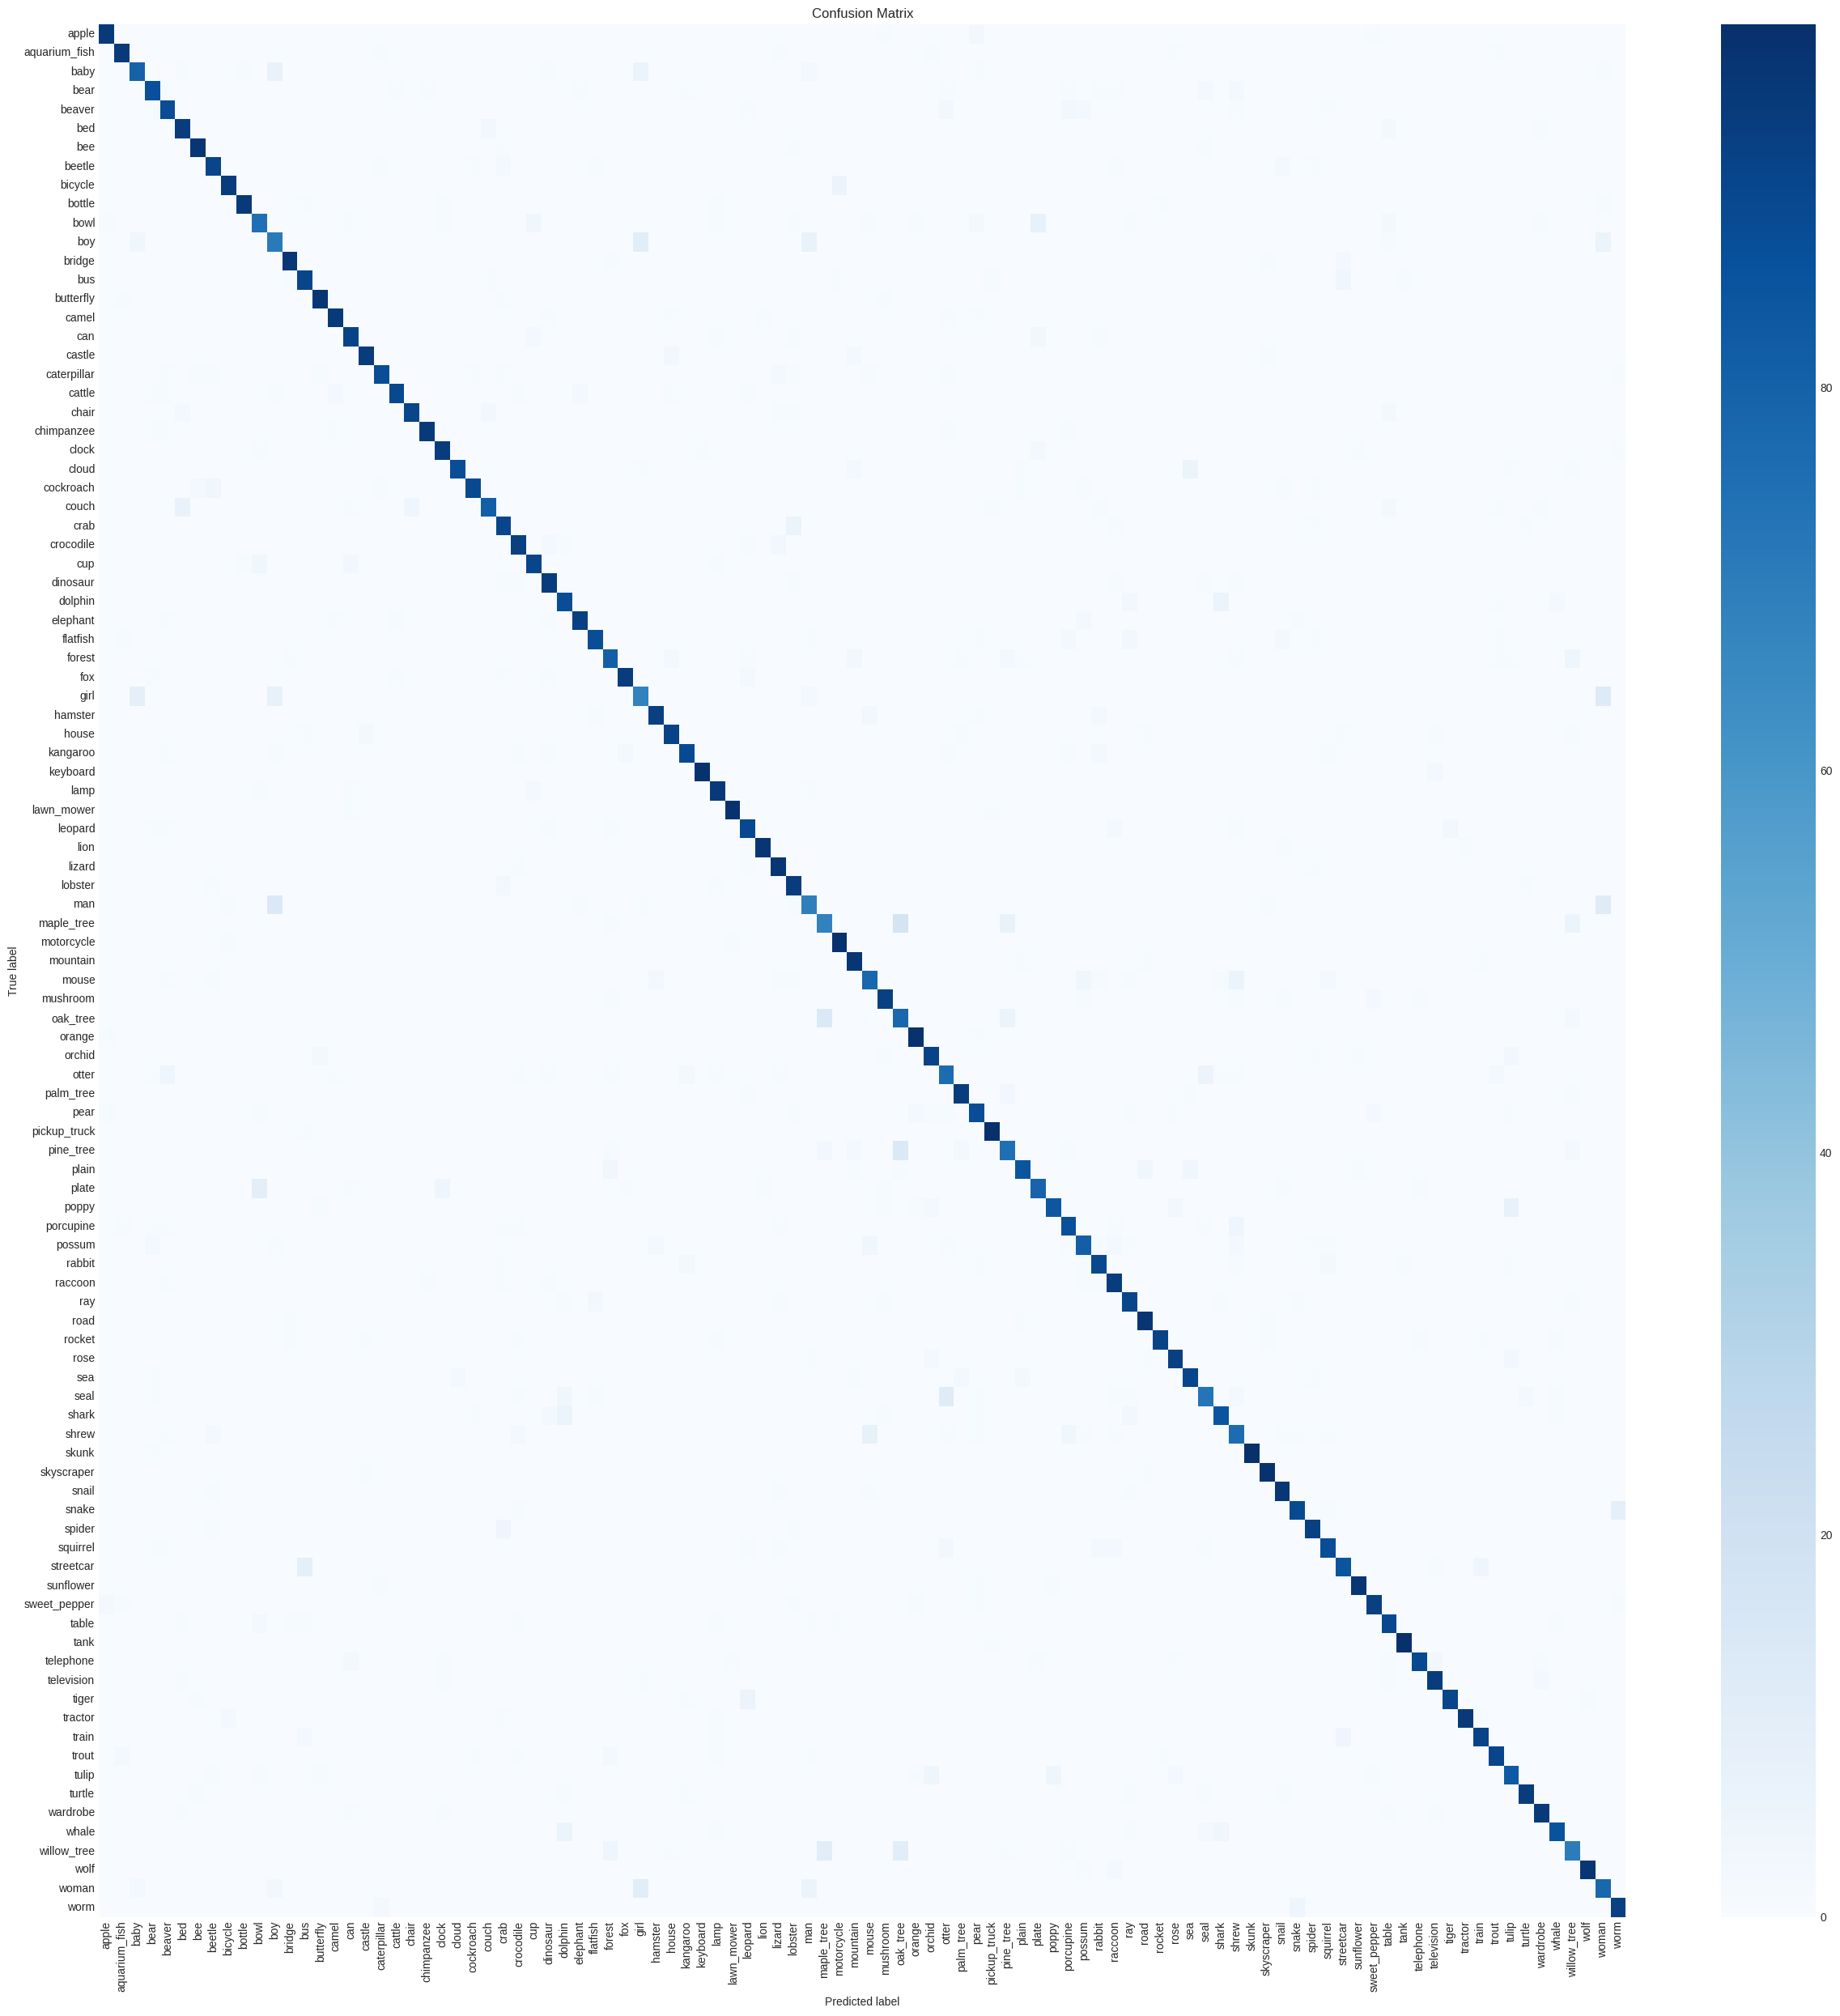


Searching for 25 misclassified images...


  0%|          | 0/209 [00:00<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 7_1_ViT_B_16_small_lr_misclassified_25.png


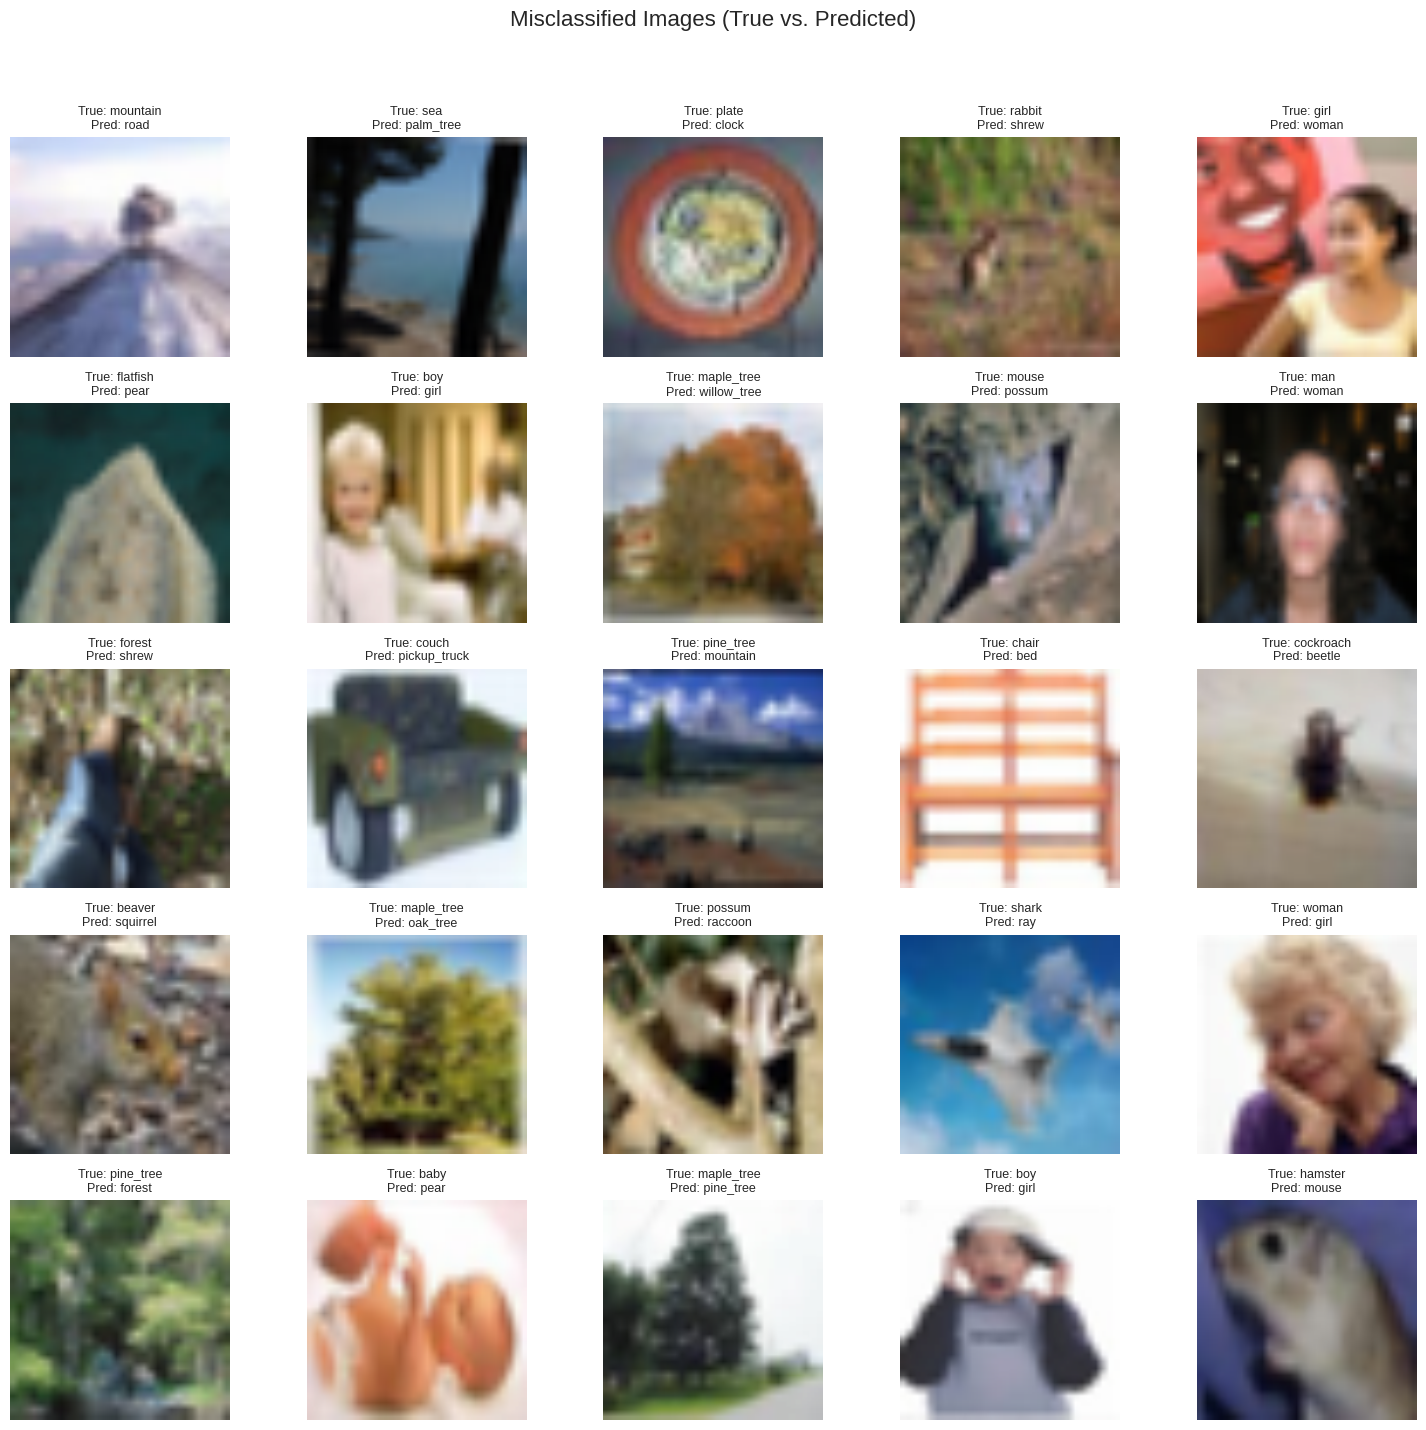

Accuracy history plot saved to 7_1_ViT_B_16_small_lr_accuracy_history.png


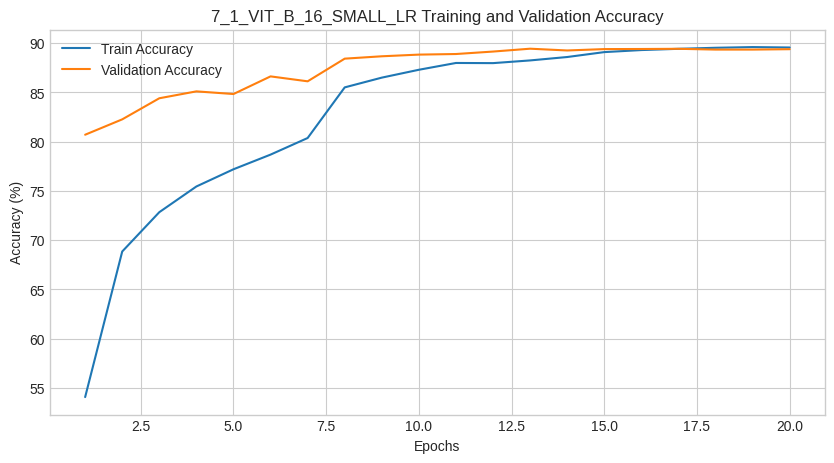

In [5]:
NUM_EPOCHS = 20
BATCH_SIZE = 48     
LEARNING_RATE = 5e-5   
IMG_SIZE = 224      
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "7_1_ViT_B_16_small_lr"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders(
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print(f"Khởi tạo {MODEL_NAME} pre-trained model...")
# Load a pre-trained Vision Transformer model
try:
    weights = models.ViT_B_16_Weights.IMAGENET1K_V1
    model = models.vit_b_16(weights=weights)
except Exception as e:
    print(f"Error loading model {MODEL_NAME}: {e}")
    print("Make sure torchvision is up to date (pip install --upgrade torchvision)")
    exit()

# Adapt the classifier head
# In ViT, the classifier head is usually called 'heads' or 'head'
if hasattr(model, 'heads') and isinstance(model.heads, nn.Sequential) and hasattr(model.heads, 'head'):
    num_ftrs = model.heads.head.in_features
    model.heads.head = nn.Linear(num_ftrs, num_classes)
    print(f"Replaced ViT classifier head (model.heads.head) with Linear({num_ftrs}, {num_classes})")
elif hasattr(model, 'head') and isinstance(model.head, nn.Linear): # For some simpler ViT implementations or older torchvision
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, num_classes)
    print(f"Replaced ViT classifier head (model.head) with Linear({num_ftrs}, {num_classes})")
else:
    print("Could not automatically find and replace the ViT classifier head.")
    print("Please inspect the model structure (print(model)) and adapt manually.")
    exit()


print(f"Bắt đầu fine-tuning {MODEL_NAME}...")
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

print(f"\n--- Performing Final Evaluation on {MODEL_NAME} ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25))

visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25,
                        filename_prefix=f'{MODEL_NAME}_misclassified')

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()